In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from multicopy_STR_genotyping import file_io, str_utils

sns.set_context("poster")
%matplotlib inline

In [3]:
df_segdup_repeats = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", 
                sep="\t", header=None, names=["chr", "start", "end", "period", "unit"])
    .assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])]))
df_pedigree = pd.read_csv("../../data/1000Genomes/1000_genomes_triad_pedigrees_subsamp.csv").drop("Unnamed: 0", axis=1).set_index("sampleID")

df_pedigree.head()

,triadID,role,pgx_id,sex,ENA_FILE_PATH,population
sampleID,,,,,,
HG00421,3,father,onekgbs-HG00421,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00422,3,mother,onekgbs-HG00422,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00423,3,child,onekgbs-HG00423,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
HG00542,21,father,onekgbs-HG00542,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00543,21,mother,onekgbs-HG00543,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS


In [4]:
bcf_files = !find ../../data/1000Genomes/ -name "fam_trio_320*.bcf"
bcf_files

['../../data/1000Genomes//GangSTR/320/fam_trio_320_GangSTR.bcf',
 '../../data/1000Genomes//variants/320/fam_trio_320.bcf']

In [32]:
df_repeats_constrain, df_samples_constrain = file_io.dfs_from_vcf("../../data/1000Genomes//variants/320/fam_trio_320.bcf")

trio_id = None
family = dict()
for sample in df_samples_constrain["sample"].unique():
    if not trio_id:
        trio_id = df_pedigree.loc[sample, "triadID"]
    family[sample] = df_pedigree.loc[sample, "role"]
if not len(family) == 3:
    raise ValueError(f"Family relationships could not be properly identified: {family}")

df_samples_constrain = df_samples_constrain.assign(
    family_id = trio_id,
    role = lambda x: [family[i] for i in x["sample"]])

df_repeats_constrain.shape, df_samples_constrain.shape

((12463, 7), (37389, 7))

In [34]:
df_samples_constrain.head()

,sample,str_id,copy_number,frequencies,genotype,family_id,role
0,HG02952,chr1_1716815,1,{38: 2},[38],320,mother
1,HG02953,chr1_1716815,2,{38: 3},"[38, 38]",320,father
2,HG02954,chr1_1716815,1,NaN,NaN,320,child
3,HG02952,chr1_1716920,1,{17: 8},[17],320,mother
4,HG02953,chr1_1716920,2,{17: 23},"[17, 17]",320,father


In [33]:
df_repeats_gangstr, df_samples_gangstr = file_io.dfs_from_vcf("../../data/1000Genomes//GangSTR/320/fam_trio_320_GangSTR.bcf", format="GangSTR")
df_samples_gangstr = df_samples_gangstr.drop("copy_number", axis=1)

trio_id = None
family = dict()
for sample in df_samples_gangstr["sample"].unique():
    if not trio_id:
        trio_id = df_pedigree.loc[sample, "triadID"]
    family[sample] = df_pedigree.loc[sample, "role"]
if not len(family) == 3:
    raise ValueError(f"Family relationships could not be properly identified: {family}")

df_samples_gangstr = df_samples_gangstr.assign(
    family_id = trio_id,
    role = lambda x: [family[i] for i in x["sample"]])

df_repeats_gangstr.shape, df_samples_gangstr.shape

((12138, 7), (36414, 6))

In [35]:
df_samples_gangstr.head()

,sample,str_id,frequencies,genotype,family_id,role
0,HG02952,chr1_1716815,{38: 2},"[38, 38]",320,mother
1,HG02953,chr1_1716815,{38: 3},"[38, 38]",320,father
2,HG02954,chr1_1716815,NaN,"[10, 10]",320,child
3,HG02952,chr1_1716920,"{17: 3, 23: 5}","[17, 23]",320,mother
4,HG02953,chr1_1716920,{23: 19},"[23, 23]",320,father


In [13]:
def filter_trio_calls(df_samples: pd.DataFrame, segdup_loci: np.array) -> pd.DataFrame:
    # first we drop observations without any reads mapped
    # or where genotype could not be estimated
    df_filt = df_samples.dropna(axis=0, how="any")
    
    # then, drop loci that are located in segmental duplications
    df_filt = df_filt.loc[~df_filt["str_id"].isin(segdup_loci)]
    
    # finally, drop loci that were not observed in all three samples
    # str_counts = df_samples.dropna(axis=0, how="any")["str_id"].value_counts()
    # observed_in_all = str_counts.loc[str_counts == 3].index
    observed_in_all = df_filt["str_id"].value_counts().where(lambda x: x == 3).dropna().index
    df_filt = df_filt.loc[df_filt["str_id"].isin(observed_in_all)].reset_index(drop=True)
    
    return df_filt
    

In [36]:
df_samples_constrain_filt = filter_trio_calls(df_samples_constrain, df_segdup_repeats["str_id"])

df_samples_constrain_filt = df_samples_constrain_filt.assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_per_cn = lambda x: x["depth"] / x["copy_number"])

df_samples_constrain.shape, df_samples_constrain_filt.shape

((37389, 7), (11709, 9))

In [39]:
df_samples_constrain_filt["child_gt_possible"] = False

possible_child_gts = []
for locus, locus_data in df_samples_constrain_filt.groupby("str_id"):
    locus_data = locus_data.set_index("role")
    
    child = np.array(locus_data.loc["child", "genotype"])
    p1 = np.array(locus_data.loc["father", "genotype"])
    p2 = np.array(locus_data.loc["mother", "genotype"])

    if str_utils.child_gt_possible(child, p1, p2):
        possible_child_gts.append(locus)

df_samples_constrain_filt = df_samples_constrain_filt.assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )

total_loci = df_samples_constrain_filt["str_id"].nunique()
consistent_loci = df_samples_constrain_filt.loc[df_samples_constrain_filt["child_gt_possible"]]["str_id"].nunique()

print(f"Family {family}:")
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")

Family {'HG02952': 'mother', 'HG02953': 'father', 'HG02954': 'child'}:
3524 out of 3903 loci (90.29%) in the child could have possibly been inherited from the parents


In [37]:
df_samples_gangstr_filt = filter_trio_calls(df_samples_gangstr, df_segdup_repeats["str_id"])

df_samples_gangstr_filt = df_samples_gangstr_filt.assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]])

df_samples_gangstr.shape, df_samples_gangstr_filt.shape

((36414, 6), (12027, 7))

In [40]:
df_samples_gangstr_filt["child_gt_possible"] = False

possible_child_gts = []
for locus, locus_data in df_samples_gangstr_filt.groupby("str_id"):
    locus_data = locus_data.set_index("role")
    
    child = np.array(locus_data.loc["child", "genotype"])
    p1 = np.array(locus_data.loc["father", "genotype"])
    p2 = np.array(locus_data.loc["mother", "genotype"])

    if str_utils.child_gt_possible(child, p1, p2):
        possible_child_gts.append(locus)

df_samples_gangstr_filt = df_samples_gangstr_filt.assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )

total_loci = df_samples_gangstr_filt["str_id"].nunique()
consistent_loci = df_samples_gangstr_filt.loc[df_samples_gangstr_filt["child_gt_possible"]]["str_id"].nunique()

print(f"Family {family}:")
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")

Family {'HG02952': 'mother', 'HG02953': 'father', 'HG02954': 'child'}:
3644 out of 4009 loci (90.90%) in the child could have possibly been inherited from the parents


In [53]:
df_merged = df_samples_gangstr_filt.merge(df_samples_constrain_filt[["sample", "str_id", "depth_per_cn", "copy_number"]], on=["sample", "str_id"], how="inner")

print(df_merged.shape)

df_merged = pd.concat([
    df_samples_constrain_filt.loc[df_samples_constrain_filt["str_id"].isin(df_samples_gangstr_filt["str_id"])].assign(method="ConSTRain"),
    df_merged.assign(method="GangSTR")
])

print(df_merged.shape)
df_merged.head()

(11361, 10)
(22722, 11)


,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,method
0,HG02952,chr1_1731381,1,{17: 14},[17],320,mother,14,14.0,True,ConSTRain
1,HG02953,chr1_1731381,2,{17: 16},"[17, 17]",320,father,16,8.0,True,ConSTRain
2,HG02954,chr1_1731381,1,{17: 12},[17],320,child,12,12.0,True,ConSTRain
3,HG02952,chr1_1731905,1,"{18: 11, 19: 1}",[18],320,mother,12,12.0,True,ConSTRain
4,HG02953,chr1_1731905,2,"{19: 27, 20: 1}","[19, 19]",320,father,28,14.0,True,ConSTRain


7280


[None]

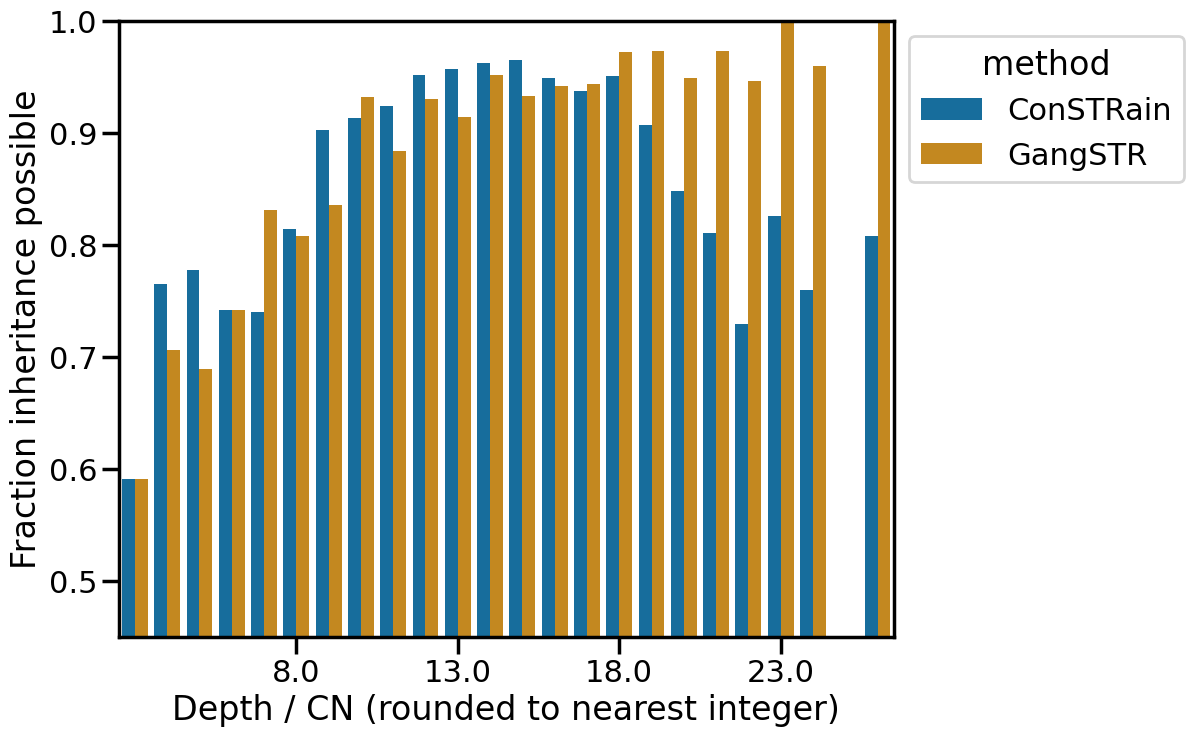

In [63]:
df_plot = (df_merged
           .query("role == 'child'")
           .assign(depth_per_cn_round = lambda x: x["depth_per_cn"].round(0))[["method", "depth_per_cn_round", "child_gt_possible"]]
           .groupby(["method", "depth_per_cn_round"], as_index=False)
           .agg(n = ("child_gt_possible", "size"), frac = ("child_gt_possible", lambda x: sum(x) / len(x)))
           .query("n >= 20")
           .reset_index(drop=True))

print(df_plot["n"].sum())

x_order = pd.Categorical(np.arange(df_plot["depth_per_cn_round"].min(), df_plot["depth_per_cn_round"].max() + 1), ordered=True)

fig = plt.figure(figsize = (10, 8))

ax = sns.barplot(
    df_plot,
    x="depth_per_cn_round",
    y="frac",    
    order=x_order,
    hue="method",
    palette="colorblind"
)

_ = ax.set(
    # xticks = np.arange(min(ax.get_xticks()), max(ax.get_xticks()), 5),
    xticks = np.arange(5, max(ax.get_xticks()), 5),
    xlabel = "Depth / CN (rounded to nearest integer)",
    ylim=(0.45, 1.0),
    ylabel="Fraction inheritance possible"
)
ax.get_legend().set(bbox_to_anchor = (1, 1))

6508


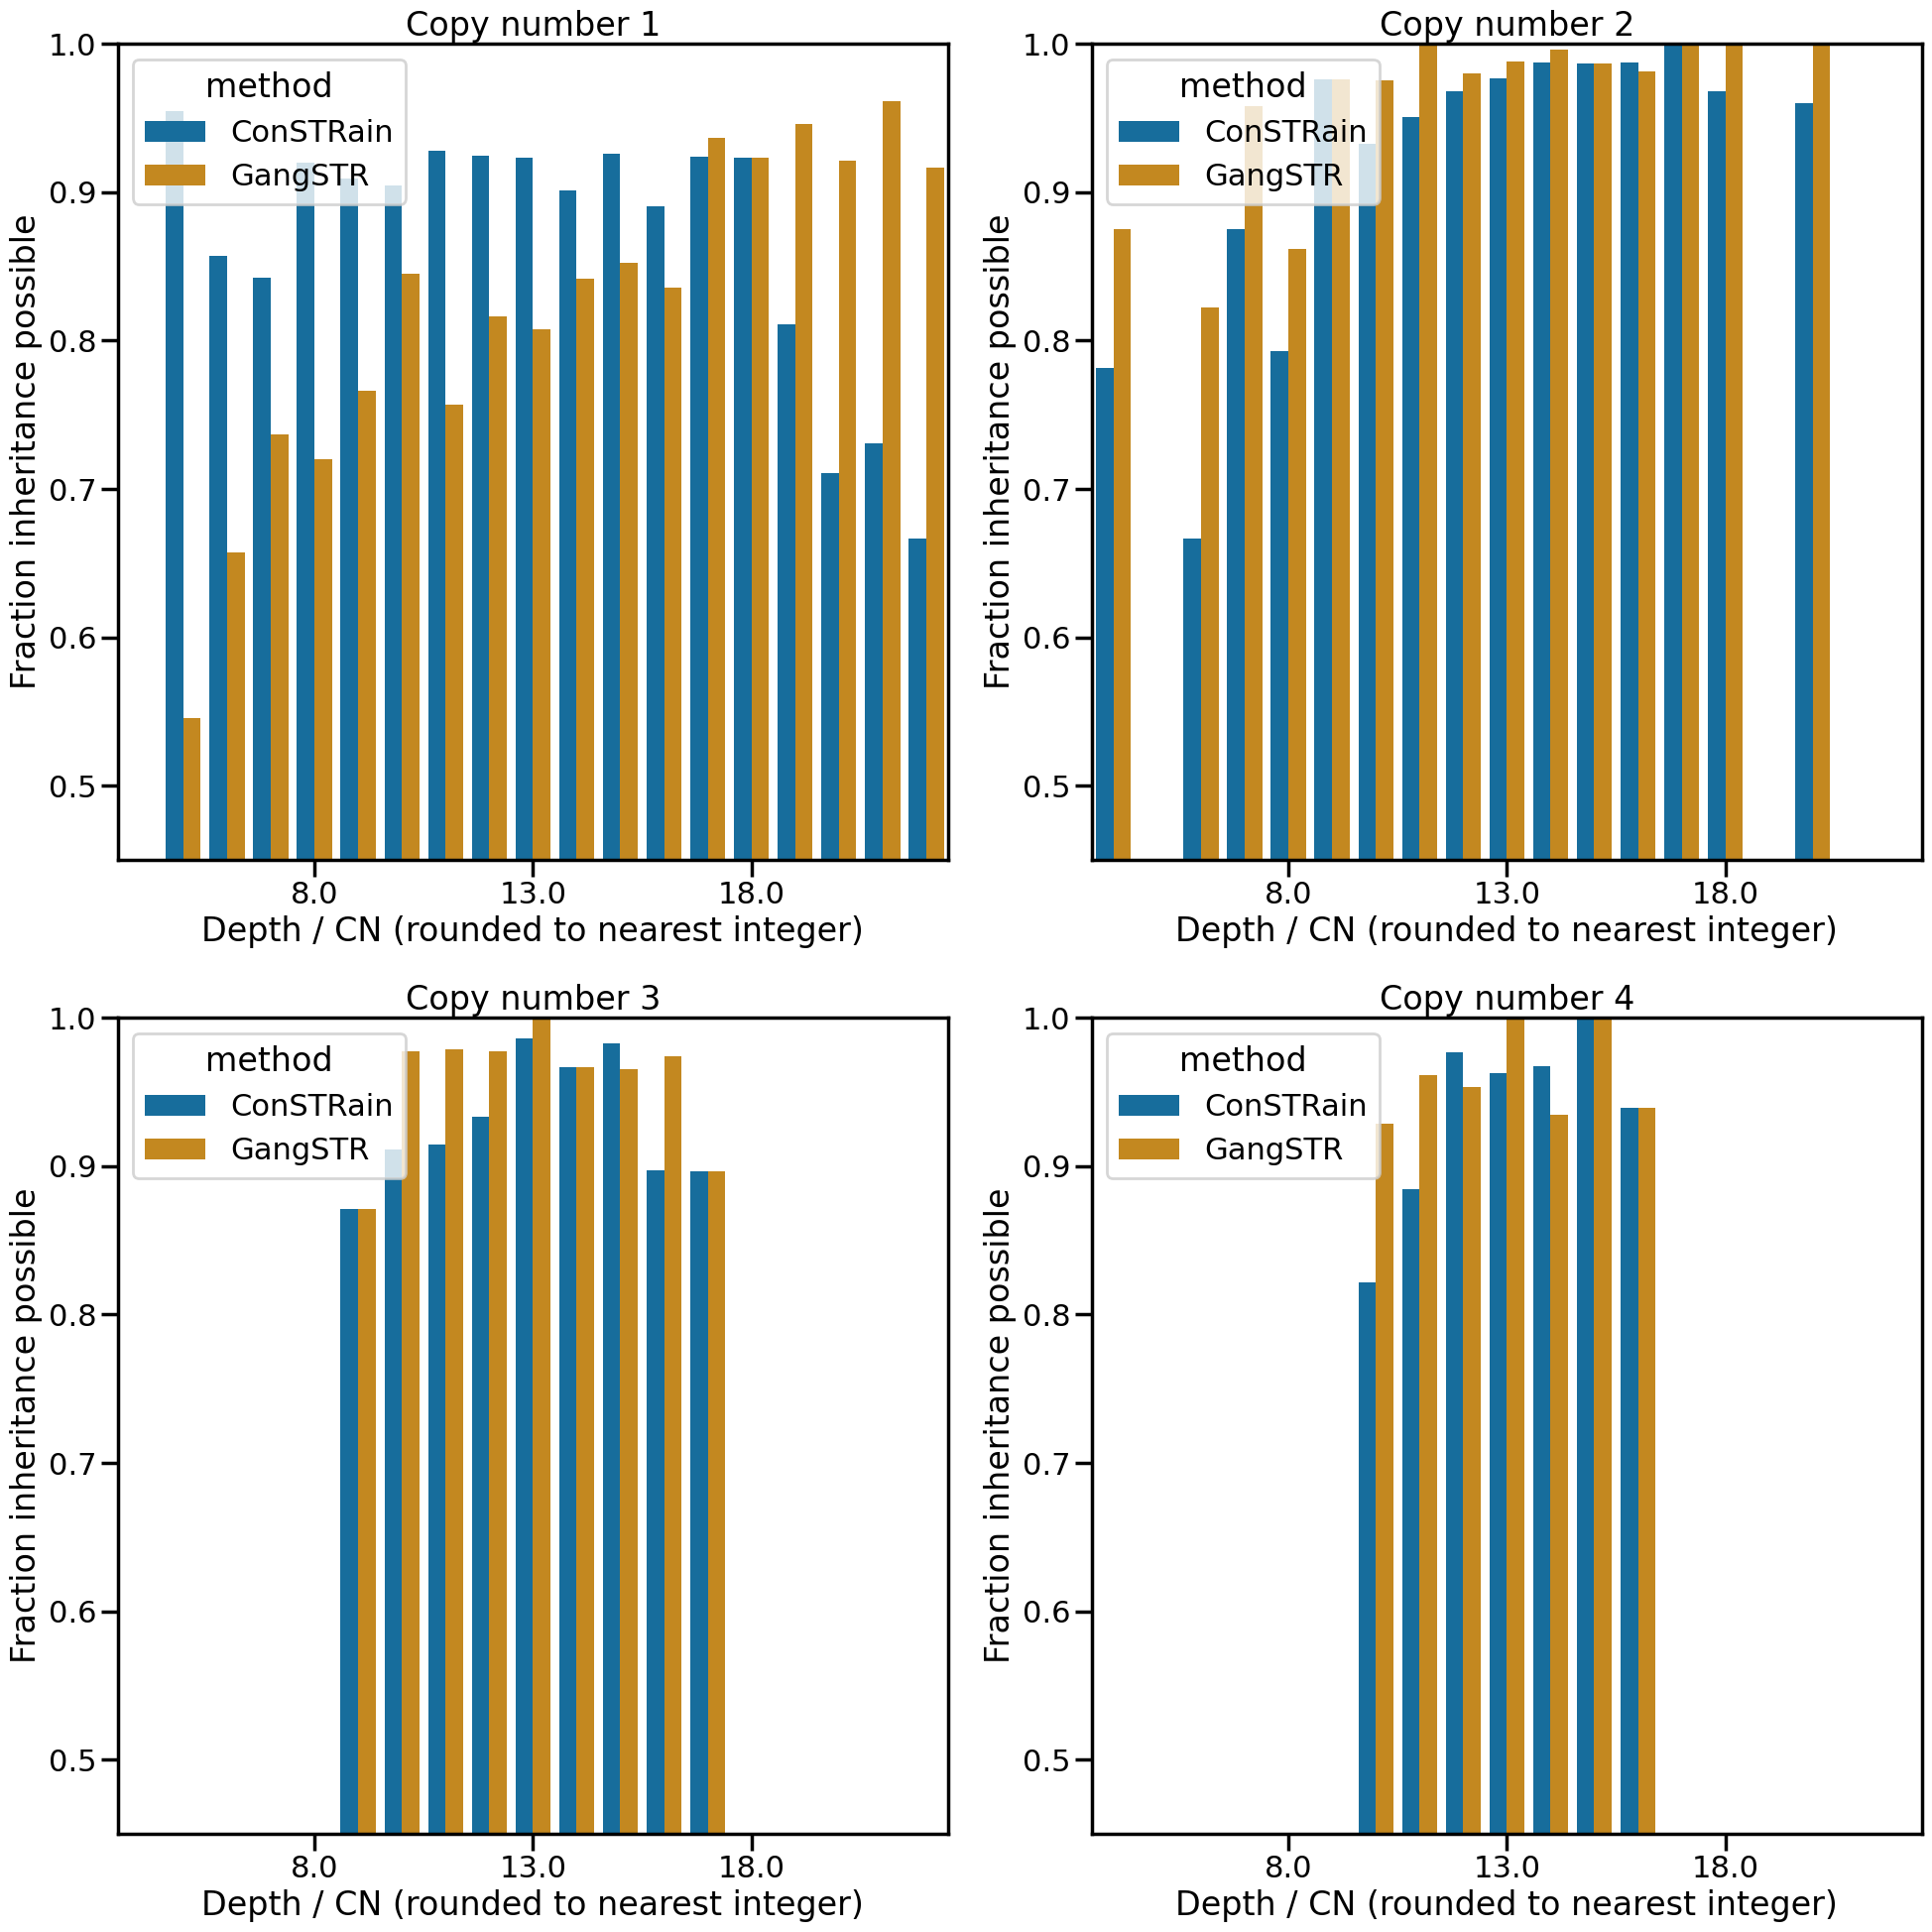

In [64]:
df_plot = (df_merged
           .query("role == 'child' and copy_number <= 4")
           .assign(depth_per_cn_round = lambda x: x["depth_per_cn"].round(0))[["method", "copy_number", "depth_per_cn_round", "child_gt_possible"]]
           .groupby(["method", "copy_number", "depth_per_cn_round"], as_index=False)
           .agg(n = ("child_gt_possible", "size"), frac = ("child_gt_possible", lambda x: sum(x) / len(x)))
           .query("n >= 20")
           .reset_index(drop=True))

print(df_plot["n"].sum())

x_order = pd.Categorical(np.arange(df_plot["depth_per_cn_round"].min(), df_plot["depth_per_cn_round"].max() + 1), ordered=True)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for ax, (group, data) in zip(np.ravel(axes), df_plot.groupby("copy_number")):
    ax = sns.barplot(
        data,
        x="depth_per_cn_round",
        y="frac",
        order=x_order,
        hue="method",
        palette="colorblind",
        ax=ax
    )

    _ = ax.set(
        title=f"Copy number {group}",
        xticks = np.arange(4, max(ax.get_xticks()), 5),
        xlabel = "Depth / CN (rounded to nearest integer)",
        ylim=(0.45, 1.0),
        ylabel="Fraction inheritance possible"
    )

plt.tight_layout()